In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

<font size=6>**Introduction to Bayesian Statistics**</font>


# 1. The problem: Counting photons...

Typically, an X-ray imaging observation gives a collection of **events**: coordinates and energies of **individual photons** detected by the telescope. Essentially, we count photons, and this is why we usually refer to the photons as **counts**, while the **count rate** informs us about the number of photons per second. In general, the count rate scales with the flux of the field (or source) in the energy band of the telescope during the observation.

<table><tr>
<td> <img src="images/NGC1482_opt.jpg" alt="Drawing" style="height:400px;"/> </td>
<td> <img src="images/NGC1482.png" alt="Drawing" style="height: 400px;"/> </td>
</tr></table>


Using **source detection algorithms** we group photons together and generate a list of sources and the photons we got from each - namely, the *source region*. For a given source, the integrated energy of the photons from its source region gives us an estimate on the energy collected from the telescope. Of course, the response of the detector and absorption effects should be accounted for. Having many counts allows us to fit for the spectrum of the source. Modeling the detector properties, the intergalactic absorption and the spectra allows us to measure the *bolometric* flux of the source - the flux as if we could observe the source with a perfect detector. Provided we know the distance of the source we can convert from flux to luminosity... an intrinsic property of the source (which is what we usually care for)!

## 1.1. How many counts are we going to get?

<font size=3><u>**In-class discussion: If each photon count corresponds to luminosity $10^{38}\,\rm erg\,s^{-1}$, and our souce is $5\times 10^{38}\,\rm erg\,s^{1}$, what is **on average** the number of counts we will measure?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Simply dividing we get the number of counts!
<br>

In [2]:
COUNT_TO_LUMINOSITY = 1.0e38  # in erg/s
source_luminosity = 5.0e38    # in erg/s
expected_counts = source_luminosity / COUNT_TO_LUMINOSITY
print(f"Expected counts: {expected_counts:.3f}")

Expected counts: 5.000


<font size=3><u>**In-class discussion: What is the distribution of the potential multiple count measurements?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
It's a counting problem, and we expect that it's measurement is independent (arrivals of photons, multiple experiments), so... it's Poisson!
    
$$P(\textrm{counts} | \textrm{expected}) = P(k | \lambda) = \textrm{Pois}(k; \lambda) = \dfrac{\lambda^k e^{-\lambda}}{k!} $$
<br>

<IPython.core.display.Javascript object>


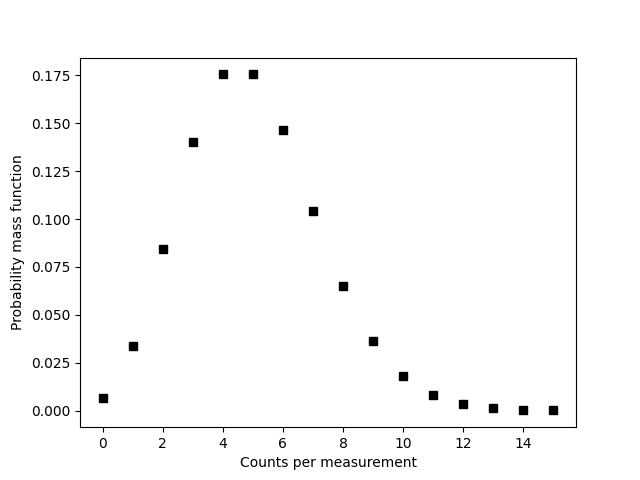

In [3]:
outcomes = np.arange(0, int(expected_counts*3)+1, 1)
pmf = st.poisson(expected_counts).pmf(outcomes)
plt.figure()
plt.plot(outcomes, pmf, "ks")
plt.xlabel("Counts per measurement")
plt.ylabel("Probability mass function")
plt.show()

<font size=3><u>**In-class discussion: What is the uncertainty on the measured counts?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Since it's Poisson, the standard deviation is the square root of the expected value!
<br>

In [4]:
counts_uncertainty = expected_counts**0.5
print(f"Uncertainty: {counts_uncertainty:.3f}")

Uncertainty: 2.236


## 1.2. Estimating the luminosity of a source


<font size=3><u>**In-class discussion: Let's do the opposite now! We found a source that emitted 5 counts. What is the luminosity of the source?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
The Poisson distribution above peaks at 5 counts, but also for 4 counts. So... if we got 4 counts, 5 would also be a good answer?
There is something weird going on! We have one measurement and we ask a question about the source! Also, we are always going to get integer multiples of the count/luminosty factor this way! But nature doesn't care about the photons we got, how far away we are, etc.
<br>

<IPython.core.display.Javascript object>


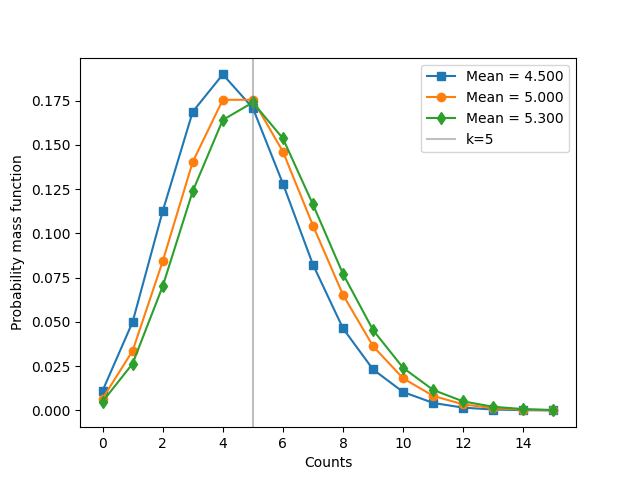

In [5]:
outcomes = np.arange(0, int(expected_counts*3)+1, 1)
plt.figure()
plt.plot(outcomes, st.poisson(expected_counts-0.5).pmf(outcomes), "s-", label=f"Mean = {expected_counts-0.5:.3f}")
plt.plot(outcomes, st.poisson(expected_counts).pmf(outcomes), "o-", label=f"Mean = {expected_counts:.3f}")
plt.plot(outcomes, st.poisson(expected_counts+0.3).pmf(outcomes), "d-", label=f"Mean = {expected_counts+0.3:.3f}")
plt.axvline(expected_counts, color="0.5", alpha=0.5, label="k=5")
plt.legend(loc="upper right")
plt.xlabel("Counts")
plt.ylabel("Probability mass function")
plt.show()

### We have multiple (actually infinite) hypothesis for the source luminosity

Before, we had the source luminosity fixed, and we wondered what we will measure, if repeating the experiment many times! This is the **frequentist approach**. And we also assigned uncertainty in the data!!!

> A frequentist assigns probabilities to data - parameters are fixed. The probability is a *frequency* of data outcomes.

But when asking about the nature of things (like in... all Science except for mathematics), then we are not interested in assigning uncertainty on the data. The data are fixed - also... they might have been fundamentally unique (some experiments cannot be repeated). We need to assign probabilities to the quantity of interest. This is the **Bayesian approach**:

$$ P(\textrm{hypothesis} | \textrm{data}) $$

> A Bayesian assigns probabilities to hypotheses. The probability is a *degree of belief* in a value of a parameter.


![image from Sivia](images/Sivia_Logic.png)


# The Bayes rule (formula, law, ...)

We need to calculate

$$ P(\textrm{hypothesis} | \textrm{data}) $$

but as we intuitively did before, we can only estimate the $$ P(\textrm{data} | \textrm{hypothesis}) $$


We can use a trick:

$$ P(A, B) = P(A | B) P(B) $$

$$ P(B, A) = P(B | A) P(A) $$

and therefore,

$$ P(A, B) = P(B, A) \quad\Rightarrow\quad P(A | B) P(B) = P(B | A) P(A) $$

which lead to the Bayes rule:

$$ P(A | B) = \dfrac{P(B | A) P(A)}{P(B)} $$

so in our case,

$$ P(\textrm{hypothesis} | \textrm{data}, I) = \dfrac{P(\textrm{data} | \textrm{hypothesis}, I) P(\textrm{hypothesis} | I)}{P(\textrm{data} | I)} $$

We made everything conditional to $I$, the **background information**: all relevant knowledge we have about the problem we are solving but are not part of the data.

For example, if we are testing whether a die is fair, the data are a sequence of outcomes (e.g., 1, 6, 3, 5, 3, 1), the hypothesis is **it's a fair die**, and $I$ = $\big\{$ all dice have 6 sides, a fair die has equiprobable sides, the Moon is not made of cheese, $\cdots \big\}$.

For brevity, **we usually omit writing the $I$** in the equations, but **it's always there**... somewhere in the background!

All the terms of this equation, the famous Bayes' rule, have names:

* **Posterior**: $P(\text{hypothesis} | \text{data}, I)$ is the degree of belief we have on the hypothesis after (a posteriori) looking at the data
* **Likelihood**: $P(\text{data | hypothesis}, I)$ is the likelihood of collecting the data at hand, given that the hypothesis is true (what a frequentist would focus on...)
* **Prior**: $P(\text{hypothesis} | I)$ is the degree of belief in the hypothesis before looking at the data (a priori). E.g., from previous studies, mathematical or physical constraints, ...
* **Evidence**: $P(\text{data} | I)$ is the probability of getting the data independently of whether the hypothesis is true or false. We almost never know the evidence and in most problems its a normalization fractor (which does not depend on the hypothesis) is not affecting the analysis!

> In Bayesian Analysis we assign degrees of belief to hypotheses (prior), which we "update" using experimental data (likelihood), to arrive to a new degree of belief in the hypotheses (posterior).

## Counting experiment: what does Reverand Bayes says about it...

$$\Large P(\text{hypothesis} | \text{data}) = P(\lambda | k) \propto P(k | \lambda) P(\lambda) $$

where we ignored the evidence since it's just a normalization constant.

### Assigning a prior belief on the source expected counts

We may have a constraint - that it cannot be above 100 because that would make it an AGN, and we know from other measurement that it's not (background information is our knowledge of how AGN work):

$$ P(\lambda | I) = 
    \begin{cases} 
    \text{const.} & 0\leq \lambda < 20 \\ 
    0 & \text{elsewhere} 
    \end{cases}
$$

The constant can be calculated by integrating the prior, but... since it's a normalization constant we can set is equal to 1, and make sure to calculate the posterior only in the permitted range of $\lambda$.

### Being completely agnostic...

Maybe we have no other information and want to be **agnostic**:

$$ P(\lambda | I) = \text{const.}, \quad \lambda \in \left(-\infty, +\infty\right) $$

This is an **improper prior** because the integral cannot be computed, but it's a common choice! Since it's just a normalization constant, it does not affect the proportionality, and it can be ignored!

Therefore,

$$\Large P(\text{hypothesis} | \text{data}) = P(\lambda | k) \propto P(k | \lambda) P(\lambda) \propto P(k | \lambda) \propto \dfrac{\lambda^k e^{-\lambda}}{k!} $$


### Are we go back to the frequentist approach using uniform prior?

No! Bayesian is not frequentism + priors! Even if the formula is the same:

$$\Large P(\lambda | k) \propto \dfrac{\lambda^k e^{-\lambda}}{k!} $$

Now, the posterior is a continuous quantity, the parameter in the Possion formula is $\lambda$, not the $k$!!!

This is in fact a $\Gamma$-distribution!!!

<IPython.core.display.Javascript object>


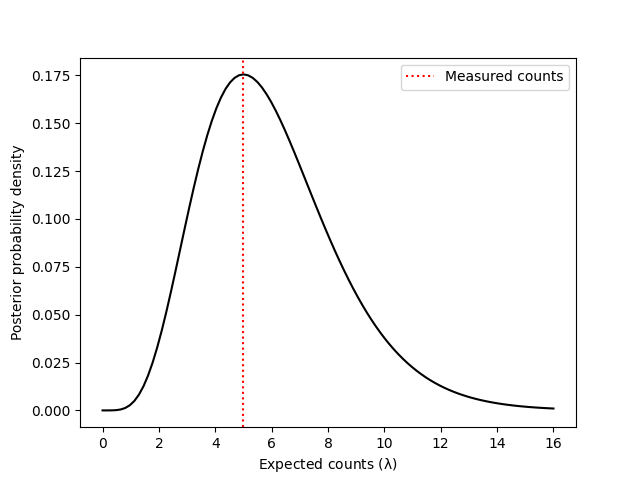

In [6]:
measure_counts = 5.0
lambda_values = np.linspace(0, int(measure_counts*3)+1, 100)
posteriors = st.poisson.pmf(measure_counts, lambda_values)

plt.figure()
plt.plot(lambda_values, posteriors, "k-")
plt.xlabel("Expected counts ($\lambda$)")
plt.ylabel("Posterior probability density")
plt.axvline(5.0, color="r", ls=":", label="Measured counts")
plt.legend(loc="upper right")
plt.show()